# Model Iterations:  Model 4

In this model I want to try building another CNN from scratch and iterate with data augmentation.

In [48]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.optimizers import RMSprop

In [21]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

parent_dir = '../../'

In [17]:
train_dir = parent_dir + 'data/seg_train/'
test_dir = parent_dir + 'data/seg_test/'
val_dir = parent_dir + 'data/seg_val/'

Rescale images and create data generators

In [46]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (256, 256), batch_size = 32)

validation_generator = val_datagen.flow_from_directory(val_dir, target_size = (256, 256), batch_size = 32)

Found 11234 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [33]:
train_generator.samples

11230

In [34]:
validation_generator.samples

2804

## Build Model 4:  CNN

In [36]:
model4 = Sequential()

# input
model4.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (256, 256, 3), data_format = "channels_last"))
model4.add(MaxPooling2D((2, 2)))

# hidden layers 
model4.add(Conv2D(128, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(256, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(256, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(128, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D((2, 2)))

# flatten layer
model4.add(Flatten())

# dense hidden layer
model4.add(Dense(512, activation = 'relu'))

# output layer
model4.add(Dense(6, activation = 'softmax'))

In [37]:
# compile
model4.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

Steps per epoch and validation steps are typically the ceiling of `num_samples / batch size` which in this case is 350 and 87 respectively (I ended up aborting this because it was taking too long).  I'm sticking with 25 epochs for this model since model 3.1 showed significant overfitting at this point with this same batch size.  So I want to see if adding more layers helps with the overfitting before I try regularisation.  

In [40]:
start = datetime.datetime.now()

In [41]:
# fit model
results4 = model4.fit_generator(train_generator, steps_per_epoch = 100, epochs = 25, 
                                validation_data = validation_generator, validation_steps = 50)

Epoch 1/25
100/100 [==============================] - 836s 8s/step - loss: 1.0768 - accuracy: 0.5716 - val_loss: 0.7147 - val_accuracy: 0.6438
Epoch 2/25
100/100 [==============================] - 829s 8s/step - loss: 0.9406 - accuracy: 0.6213 - val_loss: 0.9123 - val_accuracy: 0.6637
Epoch 3/25
100/100 [==============================] - 831s 8s/step - loss: 0.9088 - accuracy: 0.6372 - val_loss: 0.6343 - val_accuracy: 0.6719
Epoch 4/25
100/100 [==============================] - 835s 8s/step - loss: 0.8466 - accuracy: 0.6834 - val_loss: 1.1564 - val_accuracy: 0.6278
Epoch 5/25
100/100 [==============================] - 829s 8s/step - loss: 0.7708 - accuracy: 0.7031 - val_loss: 0.5692 - val_accuracy: 0.7312
Epoch 6/25
100/100 [==============================] - 3575s 36s/step - loss: 0.7003 - accuracy: 0.7330 - val_loss: 0.7788 - val_accuracy: 0.7141
Epoch 7/25
100/100 [==============================] - 893s 9s/step - loss: 0.7175 - accuracy: 0.7253 - val_loss: 0.5263 - val_accuracy: 0.77

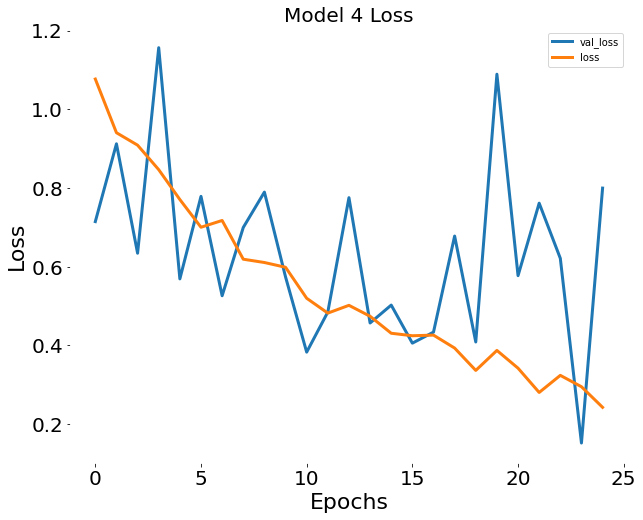

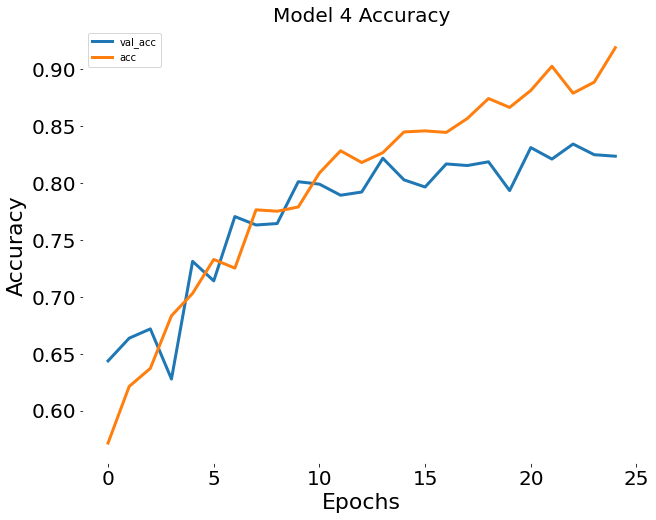

In [43]:
history = results4.history
plt.figure(figsize = (10, 8))
plt.plot(history['val_loss'], lw = 3)
plt.plot(history['loss'], lw = 3)
plt.legend(['val_loss', 'loss'])
plt.title('Model 4 Loss')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Loss', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model4_loss')
plt.show();

plt.figure(figsize = (10, 8))
plt.plot(history['val_accuracy'], lw = 3)
plt.plot(history['accuracy'], lw = 3)
plt.legend(['val_acc', 'acc'])
plt.title('Model 4 Accuracy')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model4_accuracy')
plt.show();

In [44]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 7:11:38.091099


### Evaluate

This model has performed the best so far with a training accuracy of 0.9191 and validation accuracy of 0.8237.  While the model is still overfitting it is the least amount of overfitting we have seen so far in our modelling.  The validation loss is still erratic in its behaviour and does not show signs of convergence yet.  Investigations into why this is happening and if there is any further data manipulation I could perform will be my next step.  

In [47]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32)
test_loss, test_acc = model4.evaluate_generator(test_generator, steps=50)
print('test loss for model 4:', test_loss)
print('test acc for model 4:', test_acc)

Found 3000 images belonging to 6 classes.


KeyboardInterrupt: 

## Model Iteration:  Model 4.1 Data Augmentation

In [61]:
start_4_1 = datetime.datetime.now()

In [62]:
train_aug_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                       shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_aug_generator = train_aug_datagen.flow_from_directory(train_dir, target_size = (299, 299), batch_size = 32)

validation_generator = val_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32)

Found 11234 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [63]:
model4_1 = Sequential()

# input
model4_1.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (299, 299, 3), data_format = "channels_last"))
model4_1.add(MaxPooling2D((2, 2)))

# hidden layers 
model4_1.add(Conv2D(128, (3, 3), activation = 'relu'))
model4_1.add(BatchNormalization())
model4_1.add(MaxPooling2D((2, 2)))

model4_1.add(Conv2D(256, (3, 3), activation = 'relu'))
model4_1.add(BatchNormalization())
model4_1.add(MaxPooling2D((2, 2)))

model4_1.add(Conv2D(256, (3, 3), activation = 'relu'))
model4_1.add(BatchNormalization())
model4_1.add(MaxPooling2D((2, 2)))

model4_1.add(Conv2D(128, (3, 3), activation = 'relu'))
model4_1.add(BatchNormalization())
model4_1.add(MaxPooling2D((2, 2)))

# flatten layer
model4_1.add(Flatten())

# dense hidden layer
model4_1.add(Dense(512, activation = 'relu'))
model4_1.add(Dropout(0.5))

# output layer
model4_1.add(Dense(6, activation = 'softmax'))

In [64]:
# compile
model4_1.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

In [65]:
callback = EarlyStopping(min_delta = 0.01, monitor = 'val_accuracy', patience = 3)
results4_1 = model4_1.fit_generator(train_generator, steps_per_epoch = 100, epochs = 50 , 
                                    validation_data = validation_generator, validation_steps = 50,
                                   callbacks = [callback])

Epoch 1/50
 99/100 [============================>.] - ETA: 12s - loss: 2.5103 - accuracy: 0.4681

ValueError: Error when checking input: expected conv2d_59_input to have shape (256, 256, 3) but got array with shape (299, 299, 3)

In [ ]:
history = results4_1.history
plt.figure(figsize = (10, 8))
plt.plot(history['val_loss'], lw = 3)
plt.plot(history['loss'], lw = 3)
plt.legend(['val_loss', 'loss'])
plt.title('Model 4.1 Loss')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Loss', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model4_1_loss')
plt.show();

plt.figure(figsize = (10, 8))
plt.plot(history['val_accuracy'], lw = 3)
plt.plot(history['accuracy'], lw = 3)
plt.legend(['val_acc', 'acc'])
plt.title('Model 4.1 Accuracy')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model4_1_accuracy')
plt.show();

In [ ]:
end = datetime.datetime.now()
elapsed = end - start_4_1
print('Training with data augmentation took a total of {}'.format(elapsed))

## Final Evaluation

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(299, 299), batch_size=32)
test_loss, test_acc = model4_1.evaluate_generator(test_generator, steps=50)
print('test loss for model 4.1:', test_loss)
print('test acc for model 4.1:', test_acc)

In [ ]:
end = datetime.datetime.now()
elapsed = end - original_start
print('Entire notebook took a total of:\n {}'.format(elapsed))

## Save Model 4:

In [ ]:
model4.save(parent_dir + 'models/model4_save')

In [38]:
save_model(model4, filepath = parent_dir + 'models/model4', 
           overwrite = True, include_optimizer = True)

## Save Model 4.1:

In [ ]:
model4_1.save(parent_dir + 'models/model4_1_save')

In [40]:
save_model(model4_1, filepath = parent_dir + 'models/model4_1', 
          overwrite = True, include_optimizer = True)